<a href="https://colab.research.google.com/github/SergeiVKalinin/MLSTEM2025/blob/main/Day3/Day_3_PCA_EELS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Day 3. Tutorial notebook for the ML-STEM Summer School, May 19-23, 2025.

- Instructor Sergei V. Kalinin
- Data by Kevin Roccapriore (AtomQ, leave of absence from ORNL)
- Sample from Delia Milliron (UT Austin)

In [1]:
from copy import deepcopy as dc

import numpy as np
import torch
import h5py

from scipy import ndimage
from sklearn import decomposition

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Data download

Download EELS data. This is 12 EELS spectral data sets of indium-tin oxide cubes aquired by Kevin Roccapriore, measured at different resolutions and geometries. Pick the one you like!

In [2]:
%%capture
!wget https://www.dropbox.com/s/nicyvttpihzh1cd/Plasmonic_sets_7222021_fixed.npy
loadedfile = np.load("Plasmonic_sets_7222021_fixed.npy", allow_pickle=True).tolist()

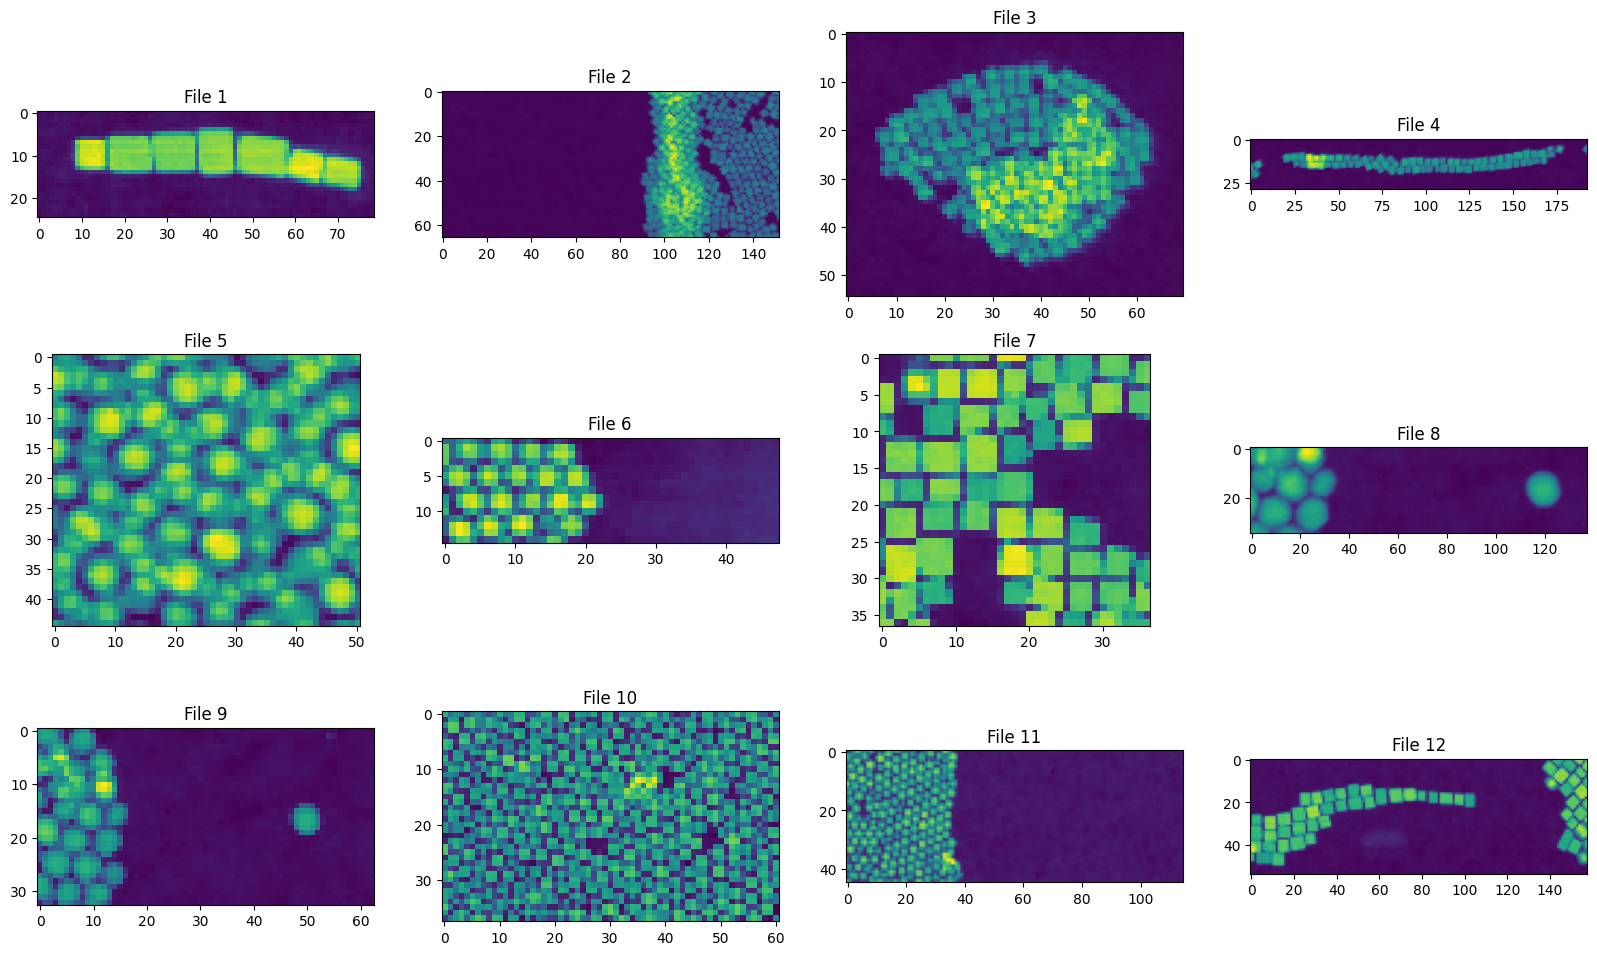

In [3]:
num_im = len(loadedfile)
rows = int(np.ceil(float(num_im)/4))
cols = int(np.ceil(float(num_im)/rows))

gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize = (5*cols, 3*(1+rows)))

for kk in range(num_im):
    ax = fig.add_subplot(gs[kk])
    fileset  = loadedfile['{}'.format(kk+1)]
    f1,f2,f3,f4 = fileset
    img, data, e_ax, img_scale = fileset[f1], fileset[f2], fileset[f3], fileset[f4]
    ax.imshow(img)
    ax.set_title("File {}".format(kk+1))

In [4]:
# Choose the file for analysis

k = 5 #3
img = loadedfile['{}'.format(k)]['image']
specim = loadedfile['{}'.format(k)]['spectrum image']
e_ax = loadedfile['{}'.format(k)]['energy axis']
imscale = loadedfile['{}'.format(k)]['scale']

In [5]:
# Read grid spectoscopy data

hdata = specim
hdata = hdata.astype(np.float64)

Visual inspection of the :

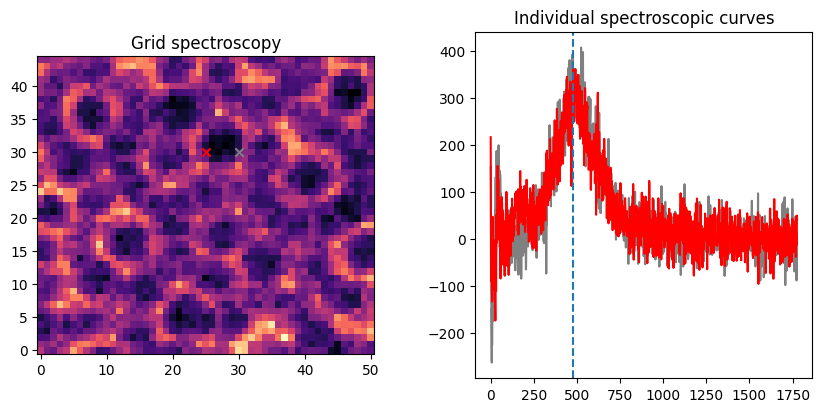

In [6]:
# Select a slice and points for extracting idividual spectoscopic curves
# For convenience, we look at the data in pixels (however, we store the real scale as e_ax)

s = 480 # slice
pos1 = [30, 30]
pos2 = [25, 30]

# Plot
_, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(hdata[..., s], cmap='magma', origin="lower")
ax[0].scatter(pos1[0], pos1[1], c='gray', marker='x')
ax[1].plot(hdata[pos1[1], pos1[0], :], c='gray')
ax[0].scatter(pos2[0], pos2[1], c='red', marker='x')
ax[1].plot(hdata[pos2[1], pos2[0], :], c='red')
ax[1].axvline(x=s, linestyle = '--')
ax[0].set_title('Grid spectroscopy')
ax[1].set_title('Individual spectroscopic curves')
plt.subplots_adjust(wspace=.3)

Important considerations for subsequent analysis.
 - For "real" analysis, make sure that before any subsequent analysis the data is properly curated. For EELS this is zero loss peak subtraction and log-log deconvolution. This will affect analysis very strongly (e.g. zerol-loss peak will dominate everything if not accounted for).
 - You can also consider downsampling the data (just average pool).
 - Finally, always keep track on whether you normalize data and how (all spectra 0 to 1, or all normalized to total maximum)
 - And keep track on whether average is subtracted.
 - Normalization and average subtraction will affect the analysis results. In our experience, there is no right way or wrong way for doing it - different preprocessing highlights dissimilar aspects of the physics of the system. However, it is important to keep track of these.  

In [7]:
X_vec = hdata.copy()
d1, d2, d3 = X_vec.shape
X_vec = X_vec.reshape(d1*d2, d3)
X_vec = (X_vec - np.min(X_vec)) / np.ptp(X_vec)

In [8]:
d1, d2, d3

(45, 51, 1777)

# PCA and NMF

First, we start with exploratory data analysis using PCA and NMF (https://en.wikipedia.org/wiki/Non-negative_matrix_factorization).

- Remember that PCA components are orthogonal, and we use truncation to select desired number of components

- NMF components are positively-defined, and we need to choose how many NMF components to use.

In [9]:
X_vec = hdata.copy()
d1, d2, d3 = X_vec.shape
X_vec = X_vec.reshape(d1*d2, d3)
X_vec = (X_vec - np.min(X_vec)) / np.ptp(X_vec)

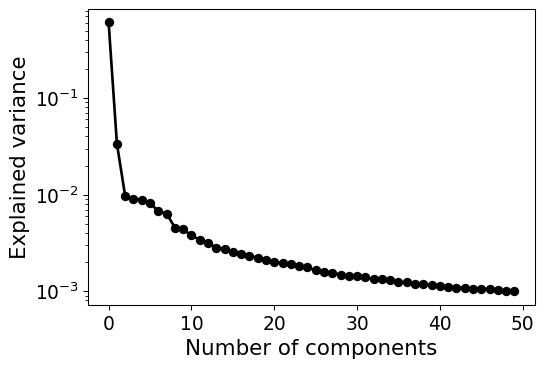

In [10]:
pca = decomposition.PCA()
pca.fit(X_vec)
plt.figure(figsize=(6, 4), dpi = 96)
plt.plot(pca.explained_variance_ratio_[0:50], '-o', linewidth=2, c = 'black')
plt.xlabel('Number of components', fontsize = 16)
plt.ylabel('Explained variance', fontsize = 16)

plt.tick_params(labelsize = 14)
plt.yscale('log')

In [11]:
# Select number of components
nc = 5

# Select decomposition type ('PCA' or 'NMF')
decomposition_type = 'PCA'

# Run decomposition
if decomposition_type == 'NMF':
    clf = decomposition.NMF(n_components=nc, random_state=42)
elif decomposition_type == 'PCA':
    clf = decomposition.PCA(n_components=nc, random_state=42)
else:
    raise NotImplementedError('Available methods: "PCA", "NMF"')
X_vec_t = clf.fit_transform(X_vec)
components = clf.components_
components = components.reshape(nc, d3)
print(components.shape, X_vec_t.shape)

(5, 1777) (2295, 5)


NUMBER OF COMPONENTS: 5
Components...


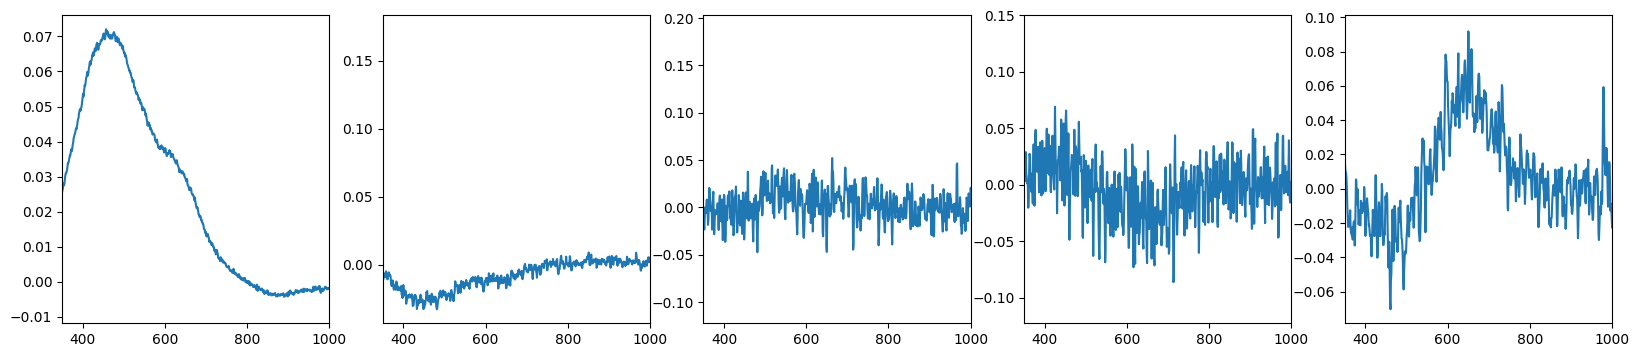

Abundance maps...


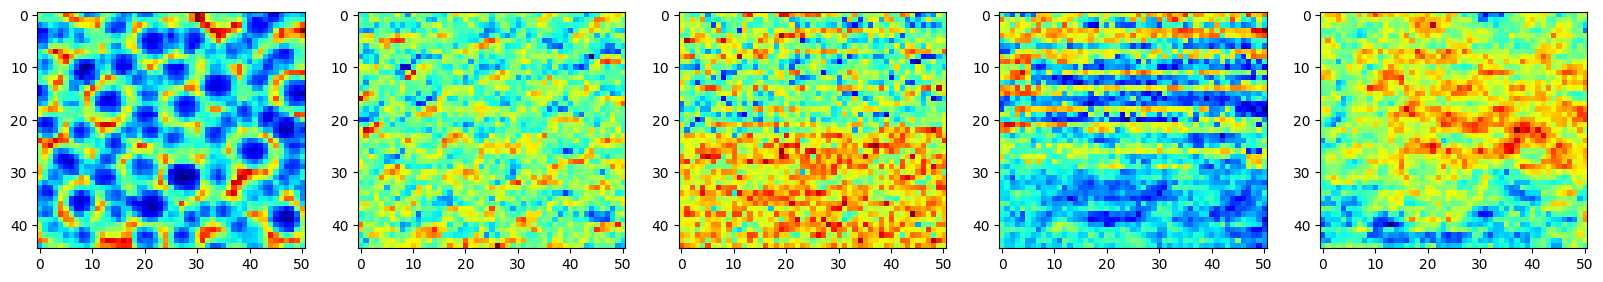

In [12]:
rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))

print('NUMBER OF COMPONENTS: ' + str(nc))
print('Components...')
gs1 = gridspec.GridSpec(rows, cols)
fig1 = plt.figure(figsize = (4*cols, 3.5*(1+rows)//1.5))
for i in range(nc):
    ax1 = fig1.add_subplot(gs1[i])
    ax1.plot(components[i])
    #ax1.set_title('Component ' + str(i + 1))
    ax1.set_xlim(350,1000)
plt.show()

print('Abundance maps...')
gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))
for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(X_vec_t[:, i].reshape(d1, d2), cmap = 'jet')
    #ax2.set_title('Component ' + str(i + 1))
plt.show()

Looks like we have quite rich structure in this material!
- Experiment witht he number of the PCA and NMF components
- What do you see?
- Any guesses how we can (qualitativley) interpret them in terms of peak positions, shifts, etc?

# Masking and analysis

We can use the PCA and NMF maps to build masks that select the regions we *think* is interetsing, and average the spectra from these regions.

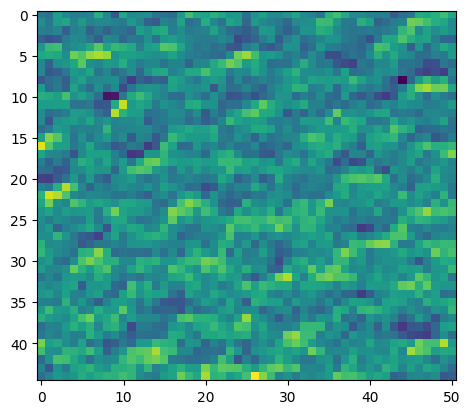

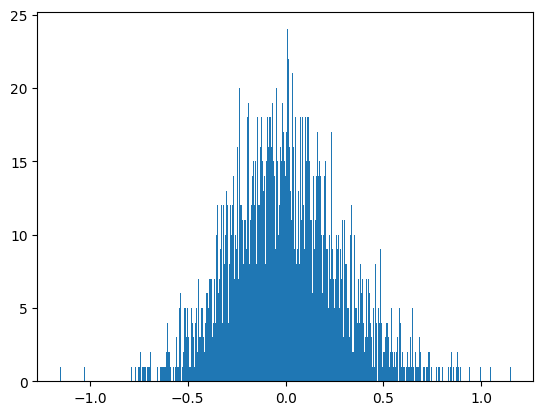

In [13]:
# Choose the image:
im_an = X_vec_t[:, 1].reshape(d1, d2)
plt.imshow(im_an)
plt.show()

# Make histogram to choose offsets
plt.hist(im_an.flatten(), bins = 500)
plt.show()

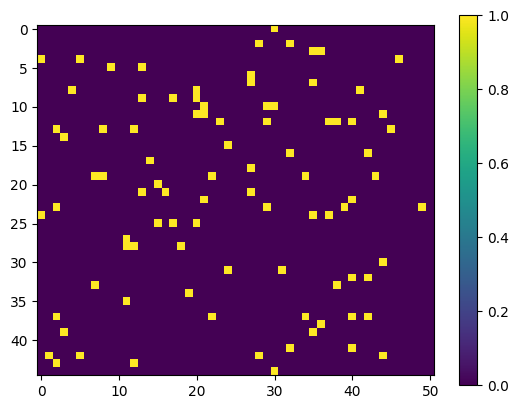

In [14]:
# Select offsets manually
# Play with the logic (i.e. > and <)
off1, off2 = 0.02, 0.05
im_cut = (im_an > off1) & (im_an < off2)

# And check binary mask (ones and zeros)
plt.imshow(im_cut)
plt.colorbar()
plt.show()

(45, 51, 1777) (45, 51)
(91, 1777)


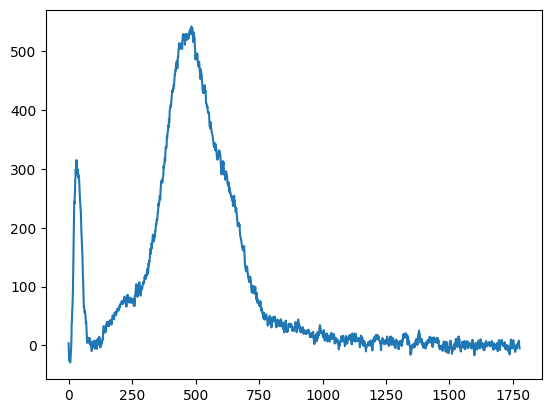

In [15]:
# We use indexing to average spectra
# Only within yellow regions

print(hdata.shape, im_cut.shape)
print(hdata[im_cut, :].shape)
av_spec = hdata[im_cut, :].mean(axis = 0)
plt.plot(av_spec)

In [16]:
im_cut.sum()

np.int64(91)

# Supervised regression

- The simplest example of the supervised analysis method is supervised linear regression. Here, we try to represent the spectrum at each location as a linear ocmbination of example spectra.
- Here, we are going to choose the "known" locations on the PCA maps to produce these endmember spectra.

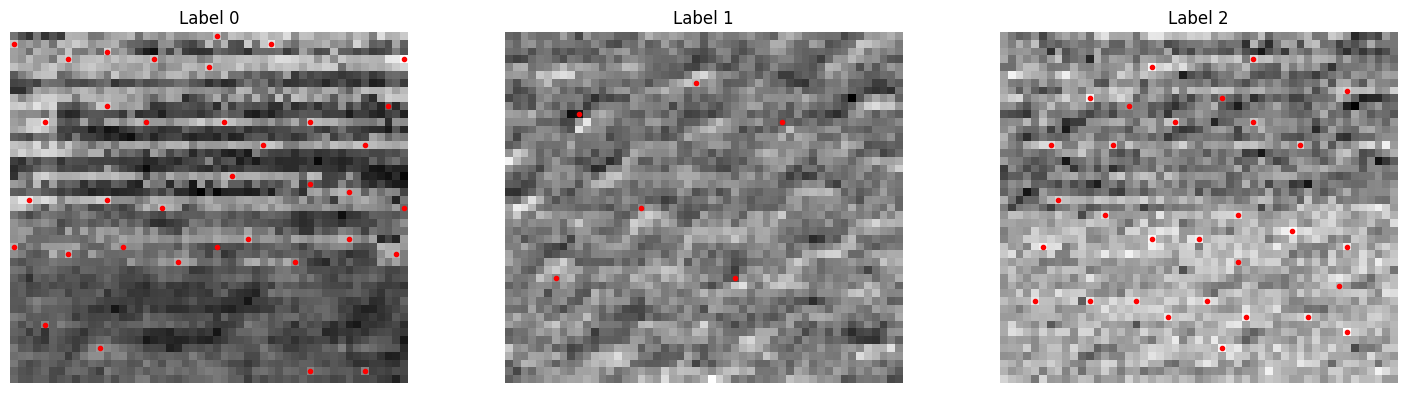

(36, 1777) (6, 1777) (30, 1777)


In [17]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

train_data = hdata
X_train = np.array(train_data)

im0 = X_vec_t[:, 3].reshape(d1, d2)
image_max0 = ndi.maximum_filter(im0, size=2, mode='constant')
coordinates0 = peak_local_max(image_max0, min_distance=3, threshold_abs = 0.08, exclude_border = False)
label0 = np.array([X_train.reshape(d1,d2,d3)[i,j,:] for i,j in coordinates0])

im1 = X_vec_t[:, 1].reshape(d1, d2)
image_max1 = ndi.maximum_filter(im1, size=4, mode='constant')
coordinates1 = peak_local_max(image_max1, min_distance=6, threshold_abs = 0.0025, exclude_border = True)
label1 = np.array([X_train.reshape(d1,d2,d3)[i,j,:] for i,j in coordinates1])

im2 = X_vec_t[:, 2].reshape(d1, d2)
image_max2 = ndi.maximum_filter(im2, size=2, mode='constant')
coordinates2 = peak_local_max(image_max2, threshold_abs = 0.05, min_distance=3)
label2 = np.array([X_train.reshape(d1,d2,d3)[i,j,:] for i,j in coordinates2])

# display results
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

ax = axes.ravel()
ax[0].imshow(im0, cmap=plt.cm.gray)
ax[0].plot(coordinates0[:, 1], coordinates0[:, 0], 'r.')
ax[0].axis('off')
ax[0].set_title('Label 0')

ax[1].imshow(im1, cmap=plt.cm.gray)
ax[1].plot(coordinates1[:, 1], coordinates1[:, 0], 'r.')
ax[1].axis('off')
ax[1].set_title('Label 1')

ax[2].imshow(im2, cmap=plt.cm.gray)
ax[2].plot(coordinates2[:, 1], coordinates2[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Label 2')

fig.tight_layout()

plt.show()

print(label0.shape, label1.shape, label2.shape)

In [18]:
imstack_train_s = np.concatenate((label0, label1, label2))

labels_train_s = np.concatenate((np.zeros(len(label0)),
                                 np.zeros(len(label1))+1,
                                 np.zeros(len(label2))+2))

print(imstack_train_s.shape, labels_train_s.shape)

(72, 1777) (72,)


Supervised regression is exactly what it souds like. Since we have already created examples of classes for the ss-VAE, we can see if the linear model works. Generally for many data set, it does work very well (since image formation mechanisms is linear). Caveat of course is that you have to know all examples.  

Text(0.5, 1.0, 'Label surface')

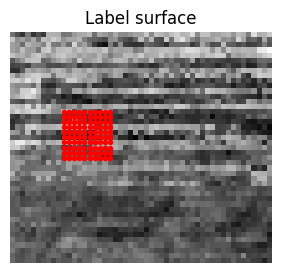

In [19]:
coordinates_surf = np.array([[i+15,j+10] for i in range(10) for j in range(10)])

plt.figure(figsize=(8, 3))
plt.imshow(im0, cmap=plt.cm.gray)
plt.plot(coordinates_surf[:, 1], coordinates_surf[:, 0], 'r.')
plt.axis('off')
plt.title('Label surface')

(45, 51, 1777)


(400.0, 1000.0)

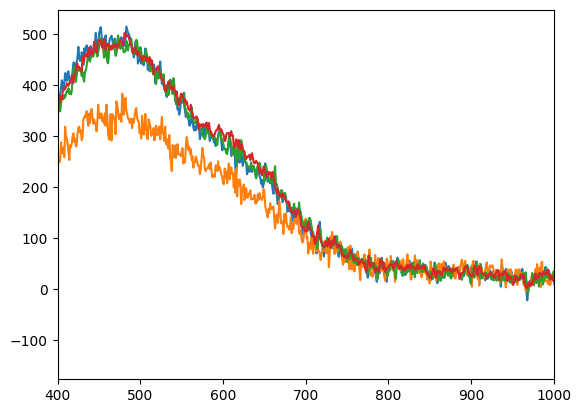

In [20]:
X_vec2 = hdata.reshape(d1, d2, d3)
print(X_vec2.shape)

surf = np.array([X_vec2[i,j,:] for i,j in coordinates_surf]).mean(axis = 0)
defect0 = np.array([X_vec2[i,j,:] for i,j in coordinates0]).mean(axis = 0)
defect1 = np.array([X_vec2[i,j,:] for i,j in coordinates1]).mean(axis = 0)
defect2 = np.array([X_vec2[i,j,:] for i,j in coordinates2]).mean(axis = 0)

plt.plot(defect0)
plt.plot(defect1)
plt.plot(defect2)
plt.plot(surf)
plt.xlim(400,1000)

This is how we implement supervised regression

In [21]:
from scipy.optimize import curve_fit
import scipy

def fn(x, a, b, c, d):
    return a*defect0 + b*defect1 + c*defect2 + d*surf

X_vec2 = X_vec2.reshape(d1*d2, d3)
ans_arr = []

for i, Xv in enumerate(X_vec2):
  popt, pcov = curve_fit(fn, np.arange(101), Xv)
  ans_arr.append(popt)

(2295, 4)


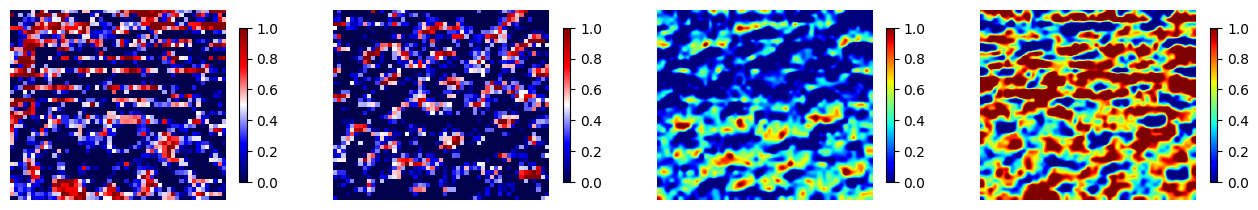

In [22]:
ans_arr = np.array(ans_arr)
print(ans_arr.shape)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4), dpi=100)

im1 = ax1.imshow(ans_arr.reshape(d1,d2,4)[:,:,0], cmap='seismic', vmin = 0, vmax = 1)
ax1.axis(False)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.5)

im2 = ax2.imshow(ans_arr.reshape(d1,d2,4)[:,:,1], cmap='seismic', vmin = 0, vmax = 1)
ax2.axis(False)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.5)

im3 = ax3.imshow(ans_arr.reshape(d1,d2,4)[:,:,2], cmap='jet', interpolation='gaussian', vmin = 0, vmax = 1)
ax3.axis(False)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.5)

im4 = ax4.imshow(ans_arr.reshape(d1,d2,4)[:,:,3], cmap='jet', interpolation='gaussian', vmin = 0, vmax = 1)
ax4.axis(False)
cbar4 = fig.colorbar(im4, ax=ax4, shrink=.5)

plt.show()

And we can present results as an RGB image (note which components we have used as RGB channels)

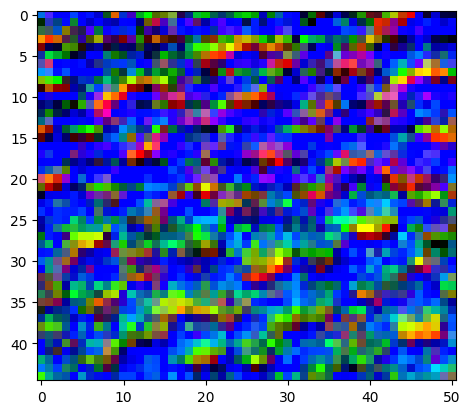

In [23]:
plt.imshow(ans_arr.reshape(d1,d2,4)[:,:,1:])